# Faims Analysis

This notebook covers the following things:
- processing
- xirt
- qc

In [1]:
import sys
sys.path.append("../") # go to parent dir
from xifaims import processing as xp
from xifaims import plots as xpl
import yaml
import seaborn as sns
import numpy as np
from IPython.display import display, HTML
import pandas as pd
import os

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy.stats import pearsonr

def find_nearest(value, array):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

# finding the best feature sub-set

This section first analyzes the different feature subsets, please see the parameter yamls for more details

In [2]:
# collect all
from glob import glob
files = glob(outdir + "/**/*all_metrics.csv", recursive=True)
files = glob("../results_merged/**/*all_metrics.csv", recursive=True)
dfs_metrics = []
for file in files:
    print (file)
    df = pd.read_csv(file)
    # simplify identification of file
    df["setting"] = os.path.basename(df["config"].iloc[0]).split(".")[0]
    dfs_metrics.append(df)
dfs_metrics = pd.concat(dfs_metrics)
dfs_metrics.head()

NameError: name 'outdir' is not defined

In [ ]:
# easier to interpret with abs
dfs_metrics["mse"] = dfs_metrics["mse"].abs()
dfs_metrics.rename(columns={"classifier": "Predictor"}, inplace=True)
# hand-crafted - few -> many features
order = ["faims_minimal", "faims_smaller", "faims_small", "faims_structure", "faims_structure_selection", "faims_all"][::-1]
# hand-crafted by performance
hue_order = ["XGBR", "XGB_sequential", "FNN", "SVR"]
# same
colors = ["#376A94", "grey", "darkgrey", "lightgrey"]
regressors = dfs_metrics[~dfs_metrics["Predictor"].str.contains("C")]
sns.catplot(y="setting", x="mse", hue="Predictor", col="split", data=regressors, kind="bar",
           col_order=["train", "test"], order=order, orient="h", hue_order=hue_order, palette=colors)
#sns.catplot(y="setting", x="mse", hue="Predictor", col="split", data=dfs_metrics[dfs_metrics["Predictor"].str.contains("C")], kind="bar",
#           col_order=["train", "test"], order=order, orient="h")
plt.savefig("model_selection.png")
plt.savefig("model_selection.svg")

In [3]:
regressors_test = regressors[regressors["split"] == "test"][["Predictor", "setting", "config", "mse"]]
table_test = regressors_test.groupby(["Predictor", "setting", "config"]).agg([np.mean, np.std])
table_test = table_test.reset_index().round(2)
table_test.columns = ["Predictor", "setting", "config", "mean(mse)", "std(mse)"]
table_test = table_test.sort_values("mean(mse)")
table_test.head(10)


NameError: name 'regressors' is not defined

### summary

The above results show that 1) XGBRegressions with static grid-search works best in this setting. The best set of features are the ones that have the most ("all", "structure_selection").
One can argue here that the difference is (probably) not significant and thus we aim for the smaller subset of feaures.

Then the question is how small ;)
- structure_selection
- structure

are both very similar in features and performance. The structure set even performs better in terms of the spread (std(mse)).

# check individual sub-set more carefully (select best performing from above)
Here we are going to look more closely into the performance features

In [176]:
option = "minimal"
option = "smaller"
#option = "small"
#option = "structure_selection"
option = "structure_selection"
#option = "all"
infile = "4PM_DSS_LS_nonunique1pCSM"
infile = "combined_8PMLunique_4PMLS_nonu"
name = f"faims_{option}-{infile}"
outdir = fr'..\results_merged\\faims_{option}-{infile}\\'
print(outdir)
metrics_df = pd.read_csv(os.path.join(outdir,r'{}_all_metrics.csv'.format(name)), index_col=0).round(2)
predictions_df = pd.read_csv(os.path.join(outdir,r'{}_summary_CV.csv'.format(name)), index_col=0).round(2)
summary_df = pd.read_csv(os.path.join(outdir,r'{}_summary_predictions.csv'.format(name)), index_col=0).round(2)
print(name)
display(predictions_df.head())
display(summary_df.head())
display(metrics_df.head())
print(metrics_df["classifier"].value_counts())

..\results_merged\\faims_structure_selection-combined_8PMLunique_4PMLS_nonu\\
faims_structure_selection-combined_8PMLunique_4PMLS_nonu


,CV_Train,CV_Predict,Set,classifier,run,config,infile
0,-55.0,-40.0,Train,SVC,faims_structure_selection-combined_8PMLunique_...,parameters/faims_structure_selection.yaml,data/combined_8PMLunique_4PMLS_nonu.csv
1,-45.0,-45.0,Train,SVC,faims_structure_selection-combined_8PMLunique_...,parameters/faims_structure_selection.yaml,data/combined_8PMLunique_4PMLS_nonu.csv
2,-40.0,-40.0,Train,SVC,faims_structure_selection-combined_8PMLunique_...,parameters/faims_structure_selection.yaml,data/combined_8PMLunique_4PMLS_nonu.csv
3,-40.0,-40.0,Train,SVC,faims_structure_selection-combined_8PMLunique_...,parameters/faims_structure_selection.yaml,data/combined_8PMLunique_4PMLS_nonu.csv
4,-55.0,-55.0,Train,SVC,faims_structure_selection-combined_8PMLunique_...,parameters/faims_structure_selection.yaml,data/combined_8PMLunique_4PMLS_nonu.csv


,clf,set,pearson,r2,mse,run
0,FNN,Test,0.66,0.43,73.97,faims_structure_selection-combined_8PMLunique_...
1,FNN,Train,0.70,0.49,69.39,faims_structure_selection-combined_8PMLunique_...
2,SVC,Test,0.33,0.11,157.71,faims_structure_selection-combined_8PMLunique_...
3,SVC,Train,0.98,0.96,4.86,faims_structure_selection-combined_8PMLunique_...
4,SVR,Test,0.61,0.37,85.35,faims_structure_selection-combined_8PMLunique_...


,cv_split,mse,split,classifier,params,config,infile,run
0,split0_test_score,0.27,test,SVC,"{'C': 100, 'gamma': 100.0, 'kernel': 'rbf'}",parameters/faims_structure_selection.yaml,data/combined_8PMLunique_4PMLS_nonu.csv,faims_structure_selection-combined_8PMLunique_...
1,split1_test_score,0.25,test,SVC,"{'C': 100, 'gamma': 100.0, 'kernel': 'rbf'}",parameters/faims_structure_selection.yaml,data/combined_8PMLunique_4PMLS_nonu.csv,faims_structure_selection-combined_8PMLunique_...
2,split2_test_score,0.27,test,SVC,"{'C': 100, 'gamma': 100.0, 'kernel': 'rbf'}",parameters/faims_structure_selection.yaml,data/combined_8PMLunique_4PMLS_nonu.csv,faims_structure_selection-combined_8PMLunique_...
3,split0_train_score,0.97,train,SVC,"{'C': 100, 'gamma': 100.0, 'kernel': 'rbf'}",parameters/faims_structure_selection.yaml,data/combined_8PMLunique_4PMLS_nonu.csv,faims_structure_selection-combined_8PMLunique_...
4,split1_train_score,0.97,train,SVC,"{'C': 100, 'gamma': 100.0, 'kernel': 'rbf'}",parameters/faims_structure_selection.yaml,data/combined_8PMLunique_4PMLS_nonu.csv,faims_structure_selection-combined_8PMLunique_...


XGBC              6
SVR               6
XGB_sequential    6
XGBR              6
SVC               6
FNN               6
Name: classifier, dtype: int64


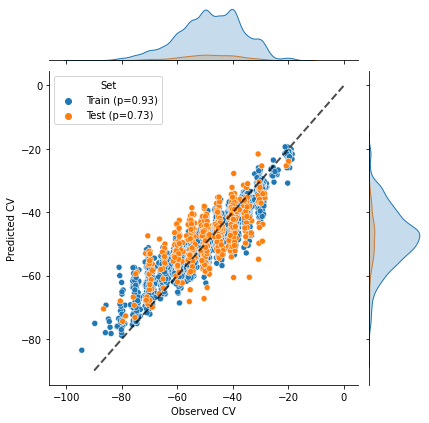

In [177]:
predictions_df = predictions_df[predictions_df["classifier"] == "XGBR"]
predictions_df2 = predictions_df.copy()
correlations = predictions_df2[['CV_Train','CV_Predict', 'Set']].groupby('Set')[['CV_Train','CV_Predict']].corr().unstack().iloc[:,1].round(2)
corr_train = correlations.loc["Train"]
corr_test = correlations.loc["Test"]
predictions_df2["CV_Train"] = np.random.normal(0, 0.75, len(predictions_df2)) + predictions_df2["CV_Train"]
predictions_df2["Set"] = predictions_df2["Set"].str.replace("Train", r"Train (p={})".format(corr_train))
predictions_df2["Set"] = predictions_df2["Set"].str.replace("Test", r"Test (p={})".format(corr_test))
g = sns.jointplot(x="CV_Train", y="CV_Predict", data=predictions_df2, hue="Set")
g.ax_joint._axes.set(xlabel="Observed CV", ylabel="Predicted CV")
g.ax_joint._axes.plot([-90, 0], [-90, 0], c="k", lw="2", alpha=0.7, ls="--")
plt.savefig("Train_test_scatter.png")
plt.savefig("Train_test_scatter.svg")
#xpl.train_test_scatter_plot(predictions_df, outdir, show=True)
#x = "CV_Train"
#y = "CV_Predict"
#predictions_df = predictions_df[predictions_df["classifier"] == "XGBR"]
#g = sns.FacetGrid(predictions_df, col="Set", row="classifier", sharex=True, sharey=True)
#g = g.map(sns.kdeplot,x, y, fill=True)#(x=x, y=y, levels=5, color="w", linewidths=1))
#g = g.map(sns.scatterplot,x, y)
#g = g.map(sns.histplot,x, y, bins=50, pthresh=0.1, cmap="viridis") #(x=x, y=y, bins=50, pthresh=.1, cmap="mako"))
#g = g.map(xpl.const_line)
#xpl.train_test_scatter_plot(predictions_df, outdir, show=True)

..\xifaims\plots.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_metrics["abs_mse"] = all_metrics["mse"].abs()


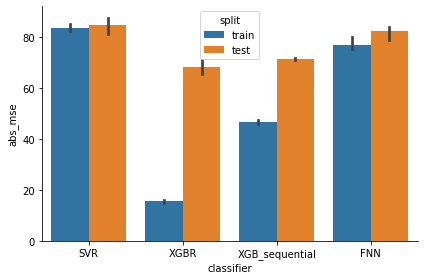

..\xifaims\plots.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_metrics["abs_mse"] = all_metrics["mse"].abs()


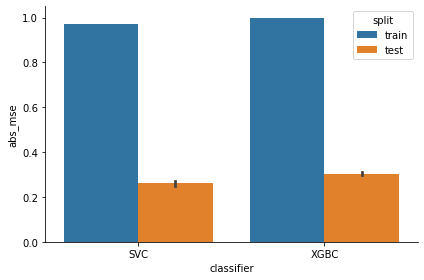

In [178]:
xpl.cv_performance_plot(metrics_df[~metrics_df["classifier"].str.contains("C")], outdir, show=True)
xpl.cv_performance_plot(metrics_df[metrics_df["classifier"].str.contains("C")], outdir, show=True)

In [67]:
unique_cv = np.array(sorted(predictions_df["CV_Train"].drop_duplicates()))
predictions_df["CV_Predict"]
predictions_df["CV_Predict_class"] = predictions_df["CV_Predict"].apply(find_nearest, args=(unique_cv,))
predictions_df.round(2)

,CV_Train,CV_Predict,Set,classifier,run,config,infile,CV_Predict_class
0,-50.0,-50.00,Train,SVC,faims_all-combined_8PMLunique_4PMLS_nonu,parameters/faims_all.yaml,data/combined_8PMLunique_4PMLS_nonu.csv,-50.0
1,-55.0,-55.00,Train,SVC,faims_all-combined_8PMLunique_4PMLS_nonu,parameters/faims_all.yaml,data/combined_8PMLunique_4PMLS_nonu.csv,-55.0
2,-55.0,-55.00,Train,SVC,faims_all-combined_8PMLunique_4PMLS_nonu,parameters/faims_all.yaml,data/combined_8PMLunique_4PMLS_nonu.csv,-55.0
3,-50.0,-50.00,Train,SVC,faims_all-combined_8PMLunique_4PMLS_nonu,parameters/faims_all.yaml,data/combined_8PMLunique_4PMLS_nonu.csv,-50.0
4,-35.0,-35.00,Train,SVC,faims_all-combined_8PMLunique_4PMLS_nonu,parameters/faims_all.yaml,data/combined_8PMLunique_4PMLS_nonu.csv,-35.0
...,...,...,...,...,...,...,...,...
4426,-50.0,-49.11,Test,FNN,faims_all-combined_8PMLunique_4PMLS_nonu,parameters/faims_all.yaml,data/combined_8PMLunique_4PMLS_nonu.csv,-50.0
4427,-50.0,-47.06,Test,FNN,faims_all-combined_8PMLunique_4PMLS_nonu,parameters/faims_all.yaml,data/combined_8PMLunique_4PMLS_nonu.csv,-45.0
4428,-50.0,-40.82,Test,FNN,faims_all-combined_8PMLunique_4PMLS_nonu,parameters/faims_all.yaml,data/combined_8PMLunique_4PMLS_nonu.csv,-40.0
4429,-40.0,-37.88,Test,FNN,faims_all-combined_8PMLunique_4PMLS_nonu,parameters/faims_all.yaml,data/combined_8PMLunique_4PMLS_nonu.csv,-40.0


,,classifier,set,accuracy,MSE,PearsonR
classifier,Set,,,,,
XGBR,Test,XGBR,Test,0.23,63.51,0.68
FNN,Test,FNN,Test,0.25,68.64,0.68
XGB_sequential,Test,XGB_sequential,Test,0.21,69.99,0.70
SVR,Test,SVR,Test,0.23,85.75,0.58
XGBC,Test,XGBC,Test,0.31,102.82,0.58
SVC,Test,SVC,Test,0.29,150.06,0.36


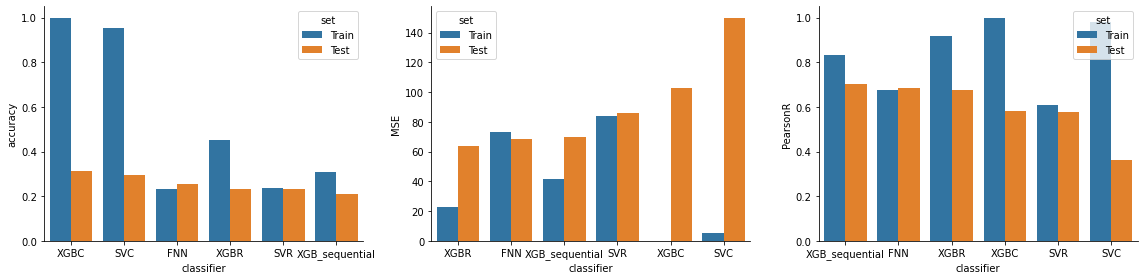

In [68]:
res1 = predictions_df.groupby(["classifier", "Set"], as_index=False).apply(lambda df: accuracy_score(df["CV_Train"], df["CV_Predict_class"]))
res2 = predictions_df.groupby(["classifier", "Set"], as_index=False).apply(lambda df: mean_squared_error(df["CV_Train"], df["CV_Predict_class"]))
res3 = predictions_df.groupby(["classifier", "Set"], as_index=False).apply(lambda df: pearsonr(df["CV_Train"], df["CV_Predict_class"])[0])
res1.columns = ["classifier", "set", "accuracy"]
res1["MSE"] = res2[None].values
res1["PearsonR"] = res3[None].values
order1 = res1[res1["set"] == "Test"].sort_values("accuracy", ascending=False)["classifier"]
order2 = res1[res1["set"] == "Test"].sort_values("MSE", ascending=True)["classifier"]
order3 = res1[res1["set"] == "Test"].sort_values("PearsonR", ascending=False)["classifier"]
res_p = res1[res1["set"] == "Test"].sort_values("MSE", ascending=True).round(2)
display(res_p)
f, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0] = sns.barplot(x="classifier", y="accuracy", hue="set", data=res1, hue_order=["Train", "Test"], order=order1, ax=ax[0])
ax[1] = sns.barplot(x="classifier", y="MSE", hue="set", data=res1, hue_order=["Train", "Test"], order=order2, ax=ax[1])
ax[2] = sns.barplot(x="classifier", y="PearsonR", hue="set", data=res1, hue_order=["Train", "Test"], order=order3, ax=ax[2])
plt.tight_layout()
for axes in ax:
    sns.despine(ax=axes)


## Interpretation

The above plot shows the train and test error (not the crossvalidation errors though).
- pearson -> higher better
- accuracy -> higher better
- mean-squared-error -> lower better

It seems like XGBoost Regressor the best performing model on average with the given feature set.